# Cell-cell communication analysis with LIANA+

This notebook shows how to:
 1. fetch publicly available datasets from the [cellxgene portal](https://cellxgene.cziscience.com/collections)
 2. perform cell-cell communication analysis in "steady state" conditions (i.e. not in a multicondition (case/control) setting) with [LIANA+](https://www.biorxiv.org/content/10.1101/2023.08.19.553863v1)

### Requirements

This notebook requires python >= 3.8. 

This notebook uses ~12GB of RAM at peak time. 

### Package imports

In [1]:
import cellxgene_census
import liana as li
import scanpy as sc

### Data loading with cellxgene census

The cellxgene portal contains hundreds of standardized data collections from scRNA-seq, scATAC-seq, spatial transcriptomics and more technologies. There are two major strategies for fetching data from the cellxgene portal:

 * **Option 1**: If you only want data from one specific dataset, you can download the associated .h5ad object locally with the **.download_source_h5ad()** function. This will allow you to retrieve the original low-dimensional embedding (e.g. PCA, scVI, UMAP, tSNE) for visualisation purposes. 
 
 * **Option 2**: If you want data from multiple datasets for specific tissue/disease status/cell types combinations of interest, you can fetch the anndata object with the **.get_anndata()** function. This will enable you to directly combine cells from multiple datasets in the same anndata object but does not retrieve any low-dimensional embedding, so you won't be able to visualise the data. If you want to subset the data of a single dataset you can also do it this way and avoid downloading anything locally. You also lose all the dataset-specific metadata which is not shared across the census.
 
For more detailed information about how to access the data hosted on the cellxgene portal have a look at their [Python API](https://chanzuckerberg.github.io/cellxgene-census/python-api.html)

#### Have a look at what is available on the cellxgene portal

In [2]:
census = cellxgene_census.open_soma()
census_datasets = census["census_info"]["datasets"].read().concat().to_pandas()

# for convenience, indexing on the soma_joinid which links this to other census data.
census_datasets = census_datasets.set_index("soma_joinid")

census_datasets

The "stable" release is currently 2023-07-25. Specify 'census_version="2023-07-25"' in future calls to open_soma() to ensure data consistency.
The "stable" release is currently 2023-07-25. Specify 'census_version="2023-07-25"' in future calls to open_soma() to ensure data consistency.


,collection_id,collection_name,collection_doi,dataset_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
soma_joinid,,,,,,,
0,e2c257e7-6f79-487c-b81c-39451cd4ab3c,Spatial multiomics map of trophoblast developm...,10.1038/s41586-023-05869-0,f171db61-e57e-4535-a06a-35d8b6ef8f2b,donor_p13_trophoblasts,f171db61-e57e-4535-a06a-35d8b6ef8f2b.h5ad,31497
1,e2c257e7-6f79-487c-b81c-39451cd4ab3c,Spatial multiomics map of trophoblast developm...,10.1038/s41586-023-05869-0,ecf2e08e-2032-4a9e-b466-b65b395f4a02,All donors trophoblasts,ecf2e08e-2032-4a9e-b466-b65b395f4a02.h5ad,67070
2,e2c257e7-6f79-487c-b81c-39451cd4ab3c,Spatial multiomics map of trophoblast developm...,10.1038/s41586-023-05869-0,74cff64f-9da9-4b2a-9b3b-8a04a1598040,All donors all cell states (in vivo),74cff64f-9da9-4b2a-9b3b-8a04a1598040.h5ad,286326
3,f7cecffa-00b4-4560-a29a-8ad626b8ee08,Mapping single-cell transcriptomes in the intr...,10.1016/j.ccell.2022.11.001,5af90777-6760-4003-9dba-8f945fec6fdf,Single-cell transcriptomic datasets of Renal c...,5af90777-6760-4003-9dba-8f945fec6fdf.h5ad,270855
4,3f50314f-bdc9-40c6-8e4a-b0901ebfbe4c,Single-cell sequencing links multiregional imm...,10.1016/j.ccell.2021.03.007,bd65a70f-b274-4133-b9dd-0d1431b6af34,Single-cell sequencing links multiregional imm...,bd65a70f-b274-4133-b9dd-0d1431b6af34.h5ad,167283
...,...,...,...,...,...,...,...
588,180bff9c-c8a5-4539-b13b-ddbc00d643e6,Molecular characterization of selectively vuln...,10.1038/s41593-020-00764-7,f9ad5649-f372-43e1-a3a8-423383e5a8a2,Molecular characterization of selectively vuln...,f9ad5649-f372-43e1-a3a8-423383e5a8a2.h5ad,8168
589,a72afd53-ab92-4511-88da-252fb0e26b9a,Single-cell atlas of peripheral immune respons...,10.1038/s41591-020-0944-y,456e8b9b-f872-488b-871d-94534090a865,Single-cell atlas of peripheral immune respons...,456e8b9b-f872-488b-871d-94534090a865.h5ad,44721
590,38833785-fac5-48fd-944a-0f62a4c23ed1,Construction of a human cell landscape at sing...,10.1038/s41586-020-2157-4,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,Construction of a human cell landscape at sing...,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf.h5ad,598266


#### Option 1: Download the **.h5ad** object of a dataset of interest locally from cellxgene

We want to look for the **core healthy integrated lung cell atlas** from [Sikkema et al 2023](https://www.nature.com/articles/s41591-023-02327-2)

In [3]:
census_datasets[census_datasets["dataset_title"].str.contains("human lung")]

,collection_id,collection_name,collection_doi,dataset_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
soma_joinid,,,,,,,
56,6f6d381a-7701-4781-935c-db10d30de293,The integrated Human Lung Cell Atlas,10.1038/s41591-023-02327-2,9f222629-9e39-47d0-b83f-e08d610c7479,An integrated cell atlas of the human lung in ...,9f222629-9e39-47d0-b83f-e08d610c7479.h5ad,2282447
425,6f6d381a-7701-4781-935c-db10d30de293,The integrated Human Lung Cell Atlas,10.1038/s41591-023-02327-2,066943a2-fdac-4b29-b348-40cede398e4e,An integrated cell atlas of the human lung in ...,066943a2-fdac-4b29-b348-40cede398e4e.h5ad,584944
456,625f6bf4-2f33-4942-962e-35243d284837,LungMAP — Human data from a broad age healthy ...,10.7554/eLife.62522,3de0ad6d-4378-4f62-b37b-ec0b75a50d94,Single-cell multiomic profiling of human lungs...,3de0ad6d-4378-4f62-b37b-ec0b75a50d94.h5ad,46500


We find the **dataset_id** for the dataset of interest and download the associated .h5ad file. This takes several minutes to download given the size (~600k cells), and it is only put here for illustrative purposes, so **you can skip this step unless you're interested in having the dataset downloaded locally**

In [4]:
cellxgene_census.download_source_h5ad(
    "066943a2-fdac-4b29-b348-40cede398e4e",
    to_path="HLCA_healthy.h5ad",  # change this to the path and file name that you prefer
)

As this dataset contains ~600k cells, we will not read it into memory and we will insted use **Option 2** to fetch only a subset of the data containing the cells from the **lung parenchyma** and from **female** individuals. 

#### Option 2: Fetch the anndata object corresponding to a query of interest in cellxgene

Let's start by looking at what cell-level metadata are available to query in cellxgene

In [5]:
list(census["census_data"]["homo_sapiens"].obs.keys())

['soma_joinid',
 'dataset_id',
 'assay',
 'assay_ontology_term_id',
 'cell_type',
 'cell_type_ontology_term_id',
 'development_stage',
 'development_stage_ontology_term_id',
 'disease',
 'disease_ontology_term_id',
 'donor_id',
 'is_primary_data',
 'self_reported_ethnicity',
 'self_reported_ethnicity_ontology_term_id',
 'sex',
 'sex_ontology_term_id',
 'suspension_type',
 'tissue',
 'tissue_ontology_term_id',
 'tissue_general',
 'tissue_general_ontology_term_id']

As you can see, for each cell-level metadata field there is the corresponding ontogeny field. Let's go ahead and fetch the data from our dataset of interest corresponding to **lung parenchyma** of **female** individuals. 

In [6]:
adata = cellxgene_census.get_anndata(
    census,
    organism="Homo sapiens",
    obs_value_filter="dataset_id == '066943a2-fdac-4b29-b348-40cede398e4e' and tissue == 'lung parenchyma' and sex == 'female'",
)

In [7]:
adata

AnnData object with n_obs × n_vars = 123656 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

Subset the data to keep only the cell types with more than 100 cells

In [10]:
import numpy as np

In [14]:
# Find cell types with at least 100 cells
cell_types_with_at_least_100_cells = [
    ct for ct in np.unique(adata.obs["cell_type"]) if adata.obs[adata.obs["cell_type"] == ct].shape[0] > 100
]
len(cell_types_with_at_least_100_cells)

32

In [15]:
# Subset the AnnData object to include only the selected cell types
adata = adata[adata.obs["cell_type"].isin(cell_types_with_at_least_100_cells)]

In [16]:
adata.shape

(123208, 60664)

### Data preprocessing

In [19]:
# in the .X slot of the anndata object we have the raw (integer) counts
adata.X[20:30, 20:30].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 4., 0., 0., 0., 1., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

As LIANA+ works with normalised and log-tranformed data, we need to perform these two steps 

In [20]:
# Filter lowly expressed genes
sc.pp.filter_genes(adata, min_cells=10)
adata.shape

/home/jovyan/my-conda-envs/ccc_env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


(123208, 23537)

In [21]:
adata.raw = adata.copy()

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [23]:
sc.pp.log1p(adata)

In [24]:
adata.X[20:30, 20:30].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.6421145 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.57734966, 0.        , 0.        , 0.        , 0.32977524,
        0.32977524, 0.        , 0.57734966, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.0628667 , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.2565256 , 0.        , 0.        , 0.        , 0.        ],
       [1.4676205 , 0.        , 0.       

In [25]:
adata.var.head()

,soma_joinid,feature_id,feature_name,feature_length,n_cells
0,0,ENSG00000121410,A1BG,3999,14962
1,1,ENSG00000268895,A1BG-AS1,3374,2382
3,3,ENSG00000175899,A2M,6318,16146
4,4,ENSG00000245105,A2M-AS1,2948,1467
5,5,ENSG00000166535,A2ML1,7156,15


For LIANA+, **.var_names** need to be set to **gene symbols** (not ENSEMBL gene IDs)

In [26]:
adata.var_names = adata.var["feature_name"].astype(str)

In [27]:
adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1', 'A4GALT', 'A4GNT',
       'AAAS', 'AACS', 'AADAC',
       ...
       'WFDC10A', 'IGLV5-48', 'IGLC5', 'PLA2G3', 'SCUBE1-AS2', 'NXF2B',
       'TCP11X2', 'RP11-635O16.2', 'RP11-533E23.2', 'RP11-566H16.2'],
      dtype='object', name='feature_name', length=23537)

For computational efficiency, we are going to downsample randomly per cell type label to a maximum of 1000 cells per cell type

In [28]:
import pandas as pd
import random
from itertools import chain

In [29]:
# Random downsampling per cell type
def downsample(adata, labels, n):
    myindex = adata.obs[labels].value_counts().index
    myvalues = adata.obs[labels].value_counts().values
    clusters = pd.Series(myvalues, index=myindex)

    # Find clusters with > n cells
    cl2downsample = clusters.index[clusters.values > n]

    # save all barcode ids from small clusters
    holder = []
    holder.append(adata.obs_names[[i not in cl2downsample for i in adata.obs[labels]]])

    # randomly sample n cells in the cl2downsample
    for cl in cl2downsample:
        print(cl)
        cl_sample = adata[[i == cl for i in adata.obs[labels]]].obs_names
        cl_downsample = random.sample(set(cl_sample), n)
        holder.append(cl_downsample)

    # samples to include
    samples = list(chain(*holder))

    # Filter adata_count
    adata = adata[[i in samples for i in adata.obs_names]]
    return adata

In [30]:
adata = downsample(adata, "cell_type", 1000)

type II pneumocyte


/tmp/ipykernel_10674/3783639370.py:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.


alveolar macrophage
natural killer cell
CD4-positive, alpha-beta T cell
CD8-positive, alpha-beta T cell
classical monocyte
elicited macrophage
capillary endothelial cell
mast cell
type I pneumocyte
CD1c-positive myeloid dendritic cell
non-classical monocyte
ciliated columnar cell of tracheobronchial tree
vein endothelial cell
alveolar type 1 fibroblast cell
pulmonary artery endothelial cell
B cell
alveolar type 2 fibroblast cell


In [31]:
adata.shape

(24694, 23537)

### Cell-cell communication inference with LIANA+

In [32]:
# import liana's rank_aggregate
from liana.mt import rank_aggregate

LIANA+ provides a consensus that integrates the predictions of individual cell-cell communication inference methods. This is done by [ranking and aggregating](https://academic.oup.com/bioinformatics/article/28/4/573/213339?login=true) the ligand-receptor interaction predictions from all methods. The methods that will be run by default in LIANA by calling the function **rank_aggregate()** are: 

 1. [CellPhoneDB](https://cellphonedb.readthedocs.io/en/latest/) with their permutation-based approach ([method 2: statistical_analysis](https://cellphonedb.readthedocs.io/en/latest/RESULTS-DOCUMENTATION.html#method-2-statistical-inference-of-interaction-specificity)) &rarr; returns both a magnitude and specificy score
 2. [Connectome](https://msraredon.github.io/Connectome/) &rarr; returns both a magnitude and specificity score
 3. [log2FC]() &rarr; returns only a specificity score 
 4. [NATMI](https://github.com/forrest-lab/NATMI/) &rarr; returns only a specificity score
 5. [SingleCellSignalR](https://www.bioconductor.org/packages/release/bioc/html/SingleCellSignalR.html) &rarr; returns only a magnitude score
 6. [CellChat](https://github.com/jinworks/CellChat) &rarr; returns both a magnitude and specificity score

In [33]:
# Run rank_aggregate --> this takes approximately 20 minutes
li.mt.rank_aggregate(
    adata,
    groupby="cell_type",  # .obs column with cell type annotations
    use_raw=False,
    expr_prop=0.1,  # minimum percentage of cells expressing ligand / receptor
    verbose=True,
)

Using `.X`!
/home/jovyan/my-conda-envs/ccc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
77 features of mat are empty, they will be removed.
Converting `cell_type` to categorical!
/home/jovyan/my-conda-envs/ccc_env/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:265: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/jovyan/my-conda-envs/ccc_env/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:142: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
['DNAJC9-AS1_ENSG00000227540', 'GOLGA8M_ENSG00000261480', 'PRICKLE2-AS1_ENSG00000241111', 'MIR1539_ENSG00000265496', 'MIR3179-3_ENSG00000257527', 'MIR3180-4_ENSG00000257391', 'CLCA

Generating ligand-receptor stats for 24694 samples and 23460 features


/home/jovyan/my-conda-envs/ccc_env/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:246: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [01:15<00:00, 13.32it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [10:31<00:00,  1.58it/s]
/home/jovyan/my-conda-envs/ccc_env/lib/python3.10/site-packages/liana/method/sc/_rank_aggregate.py:144: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


In [34]:
adata.uns["liana_res"].head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
172690,classical monocyte,type I pneumocyte,S100A9,AGER,4.104800,0.0,16.746553,3.599371,5.558186,0.147037,0.977557,0.316083,0.0,6.516201e-08,6.357762e-14
172689,classical monocyte,type I pneumocyte,S100A8,AGER,4.071708,0.0,16.496103,3.731564,5.800996,0.197601,0.977392,0.312289,0.0,6.505477e-09,1.507019e-13
27806,club cell,alveolar macrophage,SCGB3A1,MARCO,4.475138,0.0,13.800630,3.340693,4.021232,0.083267,0.975334,0.273894,0.0,3.591774e-06,2.309044e-13
130941,capillary endothelial cell,natural killer cell,B2M,KLRD1,3.929645,0.0,12.739497,2.159858,2.412535,0.015208,0.974353,0.264795,0.0,7.819353e-04,5.473256e-13
132640,natural killer cell,natural killer cell,B2M,KLRD1,3.831153,0.0,12.289257,2.061522,2.190946,0.014671,0.973900,0.255173,0.0,1.373616e-03,1.847201e-12


In [35]:
adata.uns["liana_res"].shape

(189405, 15)

In [36]:
# Reformat the output so that it's easier to understand which column corresponds to which method
def reformat_liana_output(output):
    # Give more intuitive names to columns
    column_mapping = {
        "source": "source",
        "target": "target",
        "ligand_complex": "ligand_complex",
        "receptor_complex": "receptor_complex",
        "lr_means": "CellPhoneDB_lr_means",
        "cellphone_pvals": "CellPhoneDB_pvals",
        "expr_prod": "Connectome_expr_prod",
        "scaled_weight": "Connectome_scaled_weight",
        "lr_logfc": "log2FC_lr",
        "spec_weight": "NATMI_spec_weight",
        "lrscore": "SingleCellSignalR_lr_score",
        "lr_probs": "CellChat_lr_probs",
        "cellchat_pvals": "CellChat_pvals",
        "specificity_rank": "RRA_specificity_rank",
        "magnitude_rank": "RRA_magnitude_rank",
    }
    # Use the rename method with the columns parameter and the dictionary
    output.rename(columns=column_mapping, inplace=True)
    return output

In [37]:
adata.uns["liana_res"] = reformat_liana_output(adata.uns["liana_res"])

In [38]:
adata.uns["liana_res"].head()

,source,target,ligand_complex,receptor_complex,CellPhoneDB_lr_means,CellPhoneDB_pvals,Connectome_expr_prod,Connectome_scaled_weight,log2FC_lr,NATMI_spec_weight,SingleCellSignalR_lr_score,CellChat_lr_probs,CellChat_pvals,RRA_specificity_rank,RRA_magnitude_rank
172690,classical monocyte,type I pneumocyte,S100A9,AGER,4.104800,0.0,16.746553,3.599371,5.558186,0.147037,0.977557,0.316083,0.0,6.516201e-08,6.357762e-14
172689,classical monocyte,type I pneumocyte,S100A8,AGER,4.071708,0.0,16.496103,3.731564,5.800996,0.197601,0.977392,0.312289,0.0,6.505477e-09,1.507019e-13
27806,club cell,alveolar macrophage,SCGB3A1,MARCO,4.475138,0.0,13.800630,3.340693,4.021232,0.083267,0.975334,0.273894,0.0,3.591774e-06,2.309044e-13
130941,capillary endothelial cell,natural killer cell,B2M,KLRD1,3.929645,0.0,12.739497,2.159858,2.412535,0.015208,0.974353,0.264795,0.0,7.819353e-04,5.473256e-13
132640,natural killer cell,natural killer cell,B2M,KLRD1,3.831153,0.0,12.289257,2.061522,2.190946,0.014671,0.973900,0.255173,0.0,1.373616e-03,1.847201e-12


### Plotting interactions

We can now explore the interactions that were found most significant (based on RRA specificity and magnitude scores) across methods

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


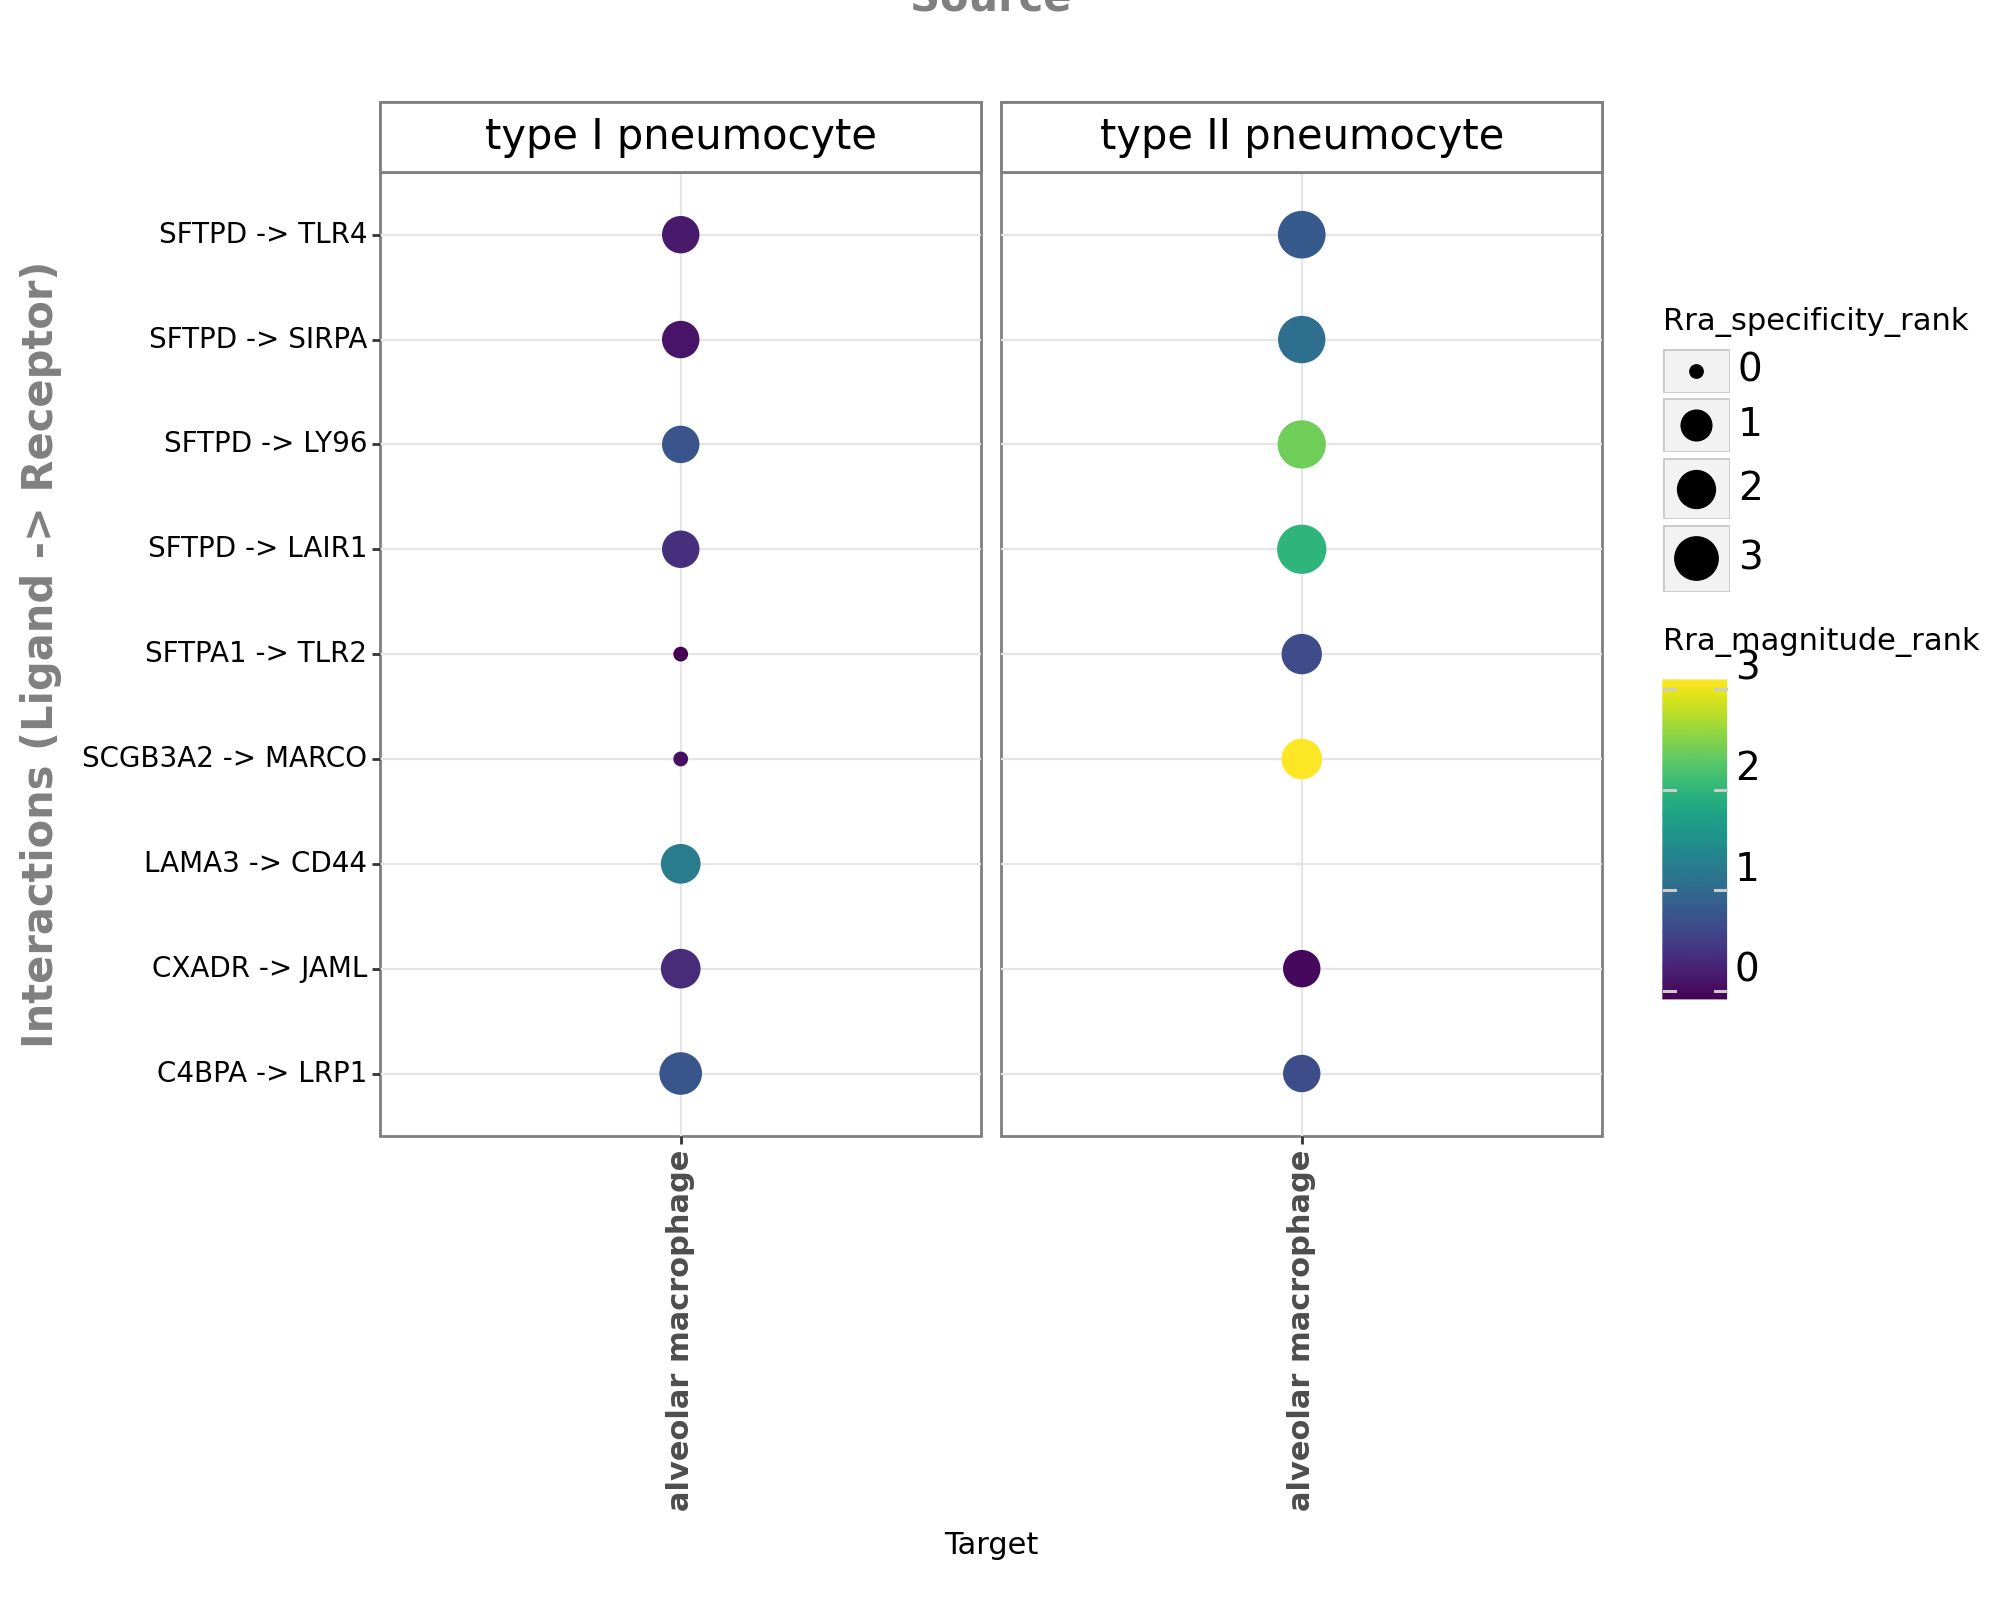

<Figure Size: (1000 x 800)>

In [55]:
li.pl.dotplot(
    adata=adata,
    colour="RRA_magnitude_rank",
    inverse_colour=True,
    size="RRA_specificity_rank",
    inverse_size=True,
    source_labels=["type I pneumocyte", "type II pneumocyte"],
    target_labels=["alveolar macrophage"],
    filterby="RRA_specificity_rank",
    filter_lambda=lambda x: x <= 0.01,
    figure_size=(10, 8),
)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


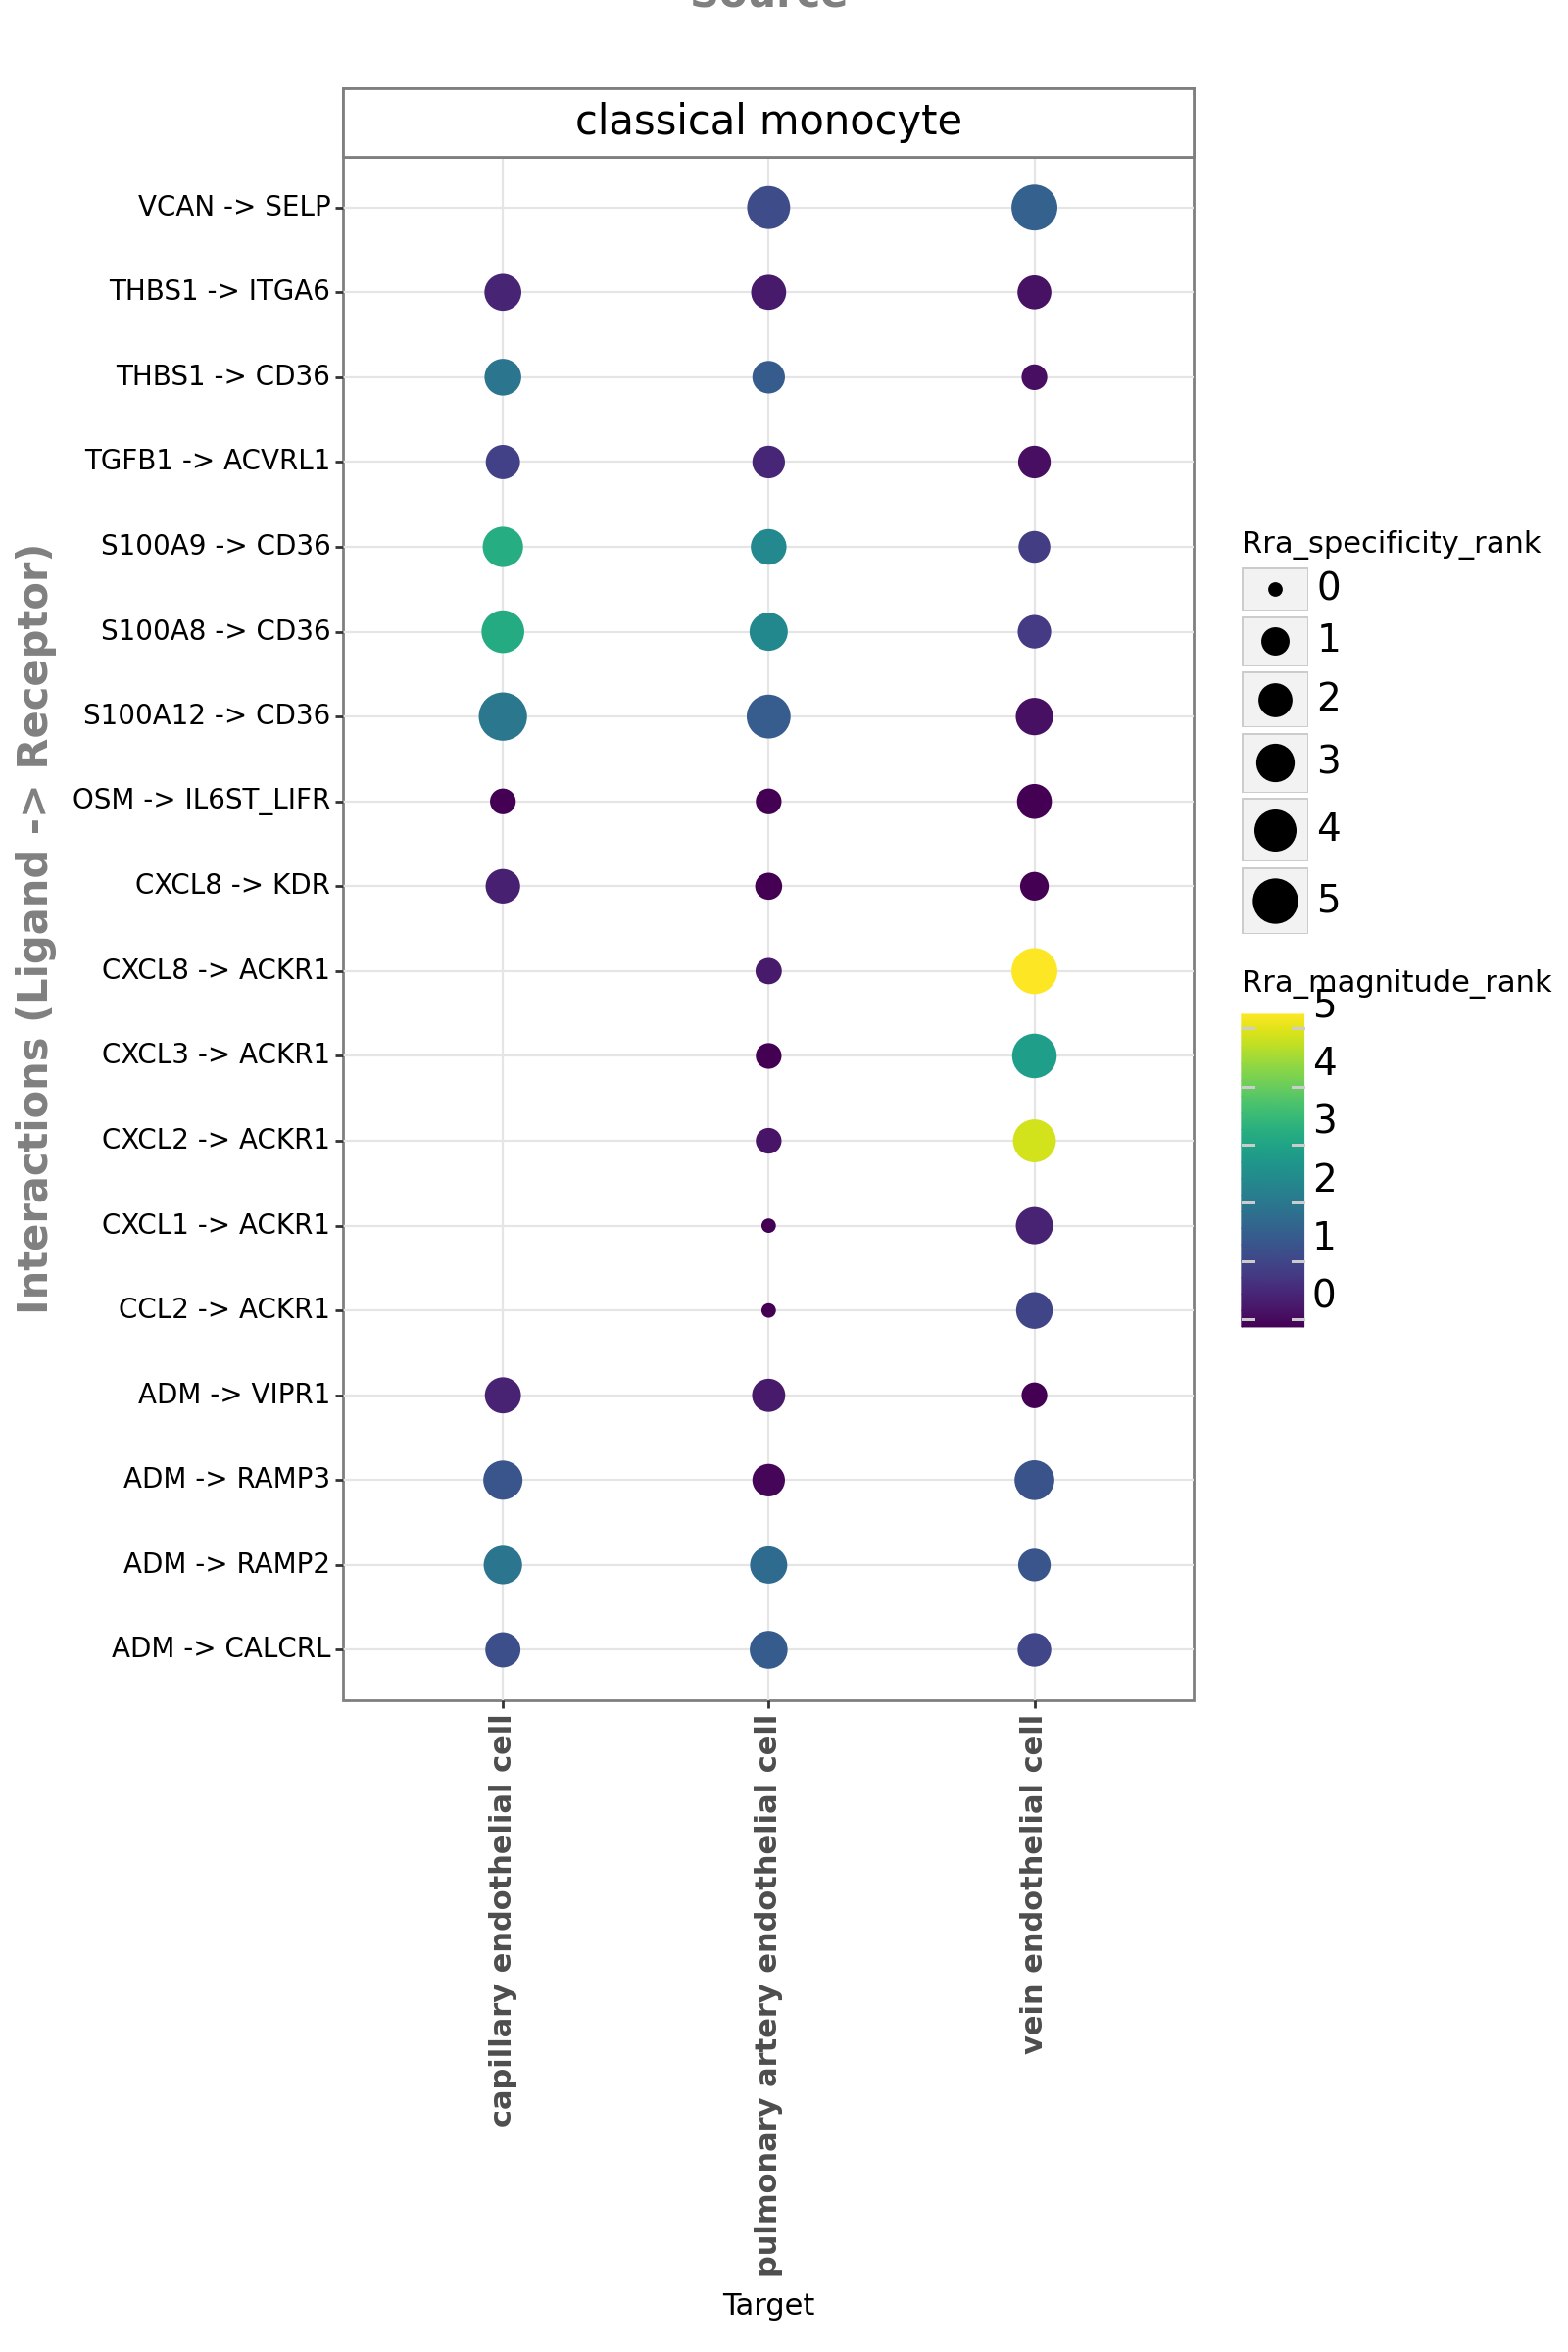

<Figure Size: (800 x 1200)>

In [51]:
li.pl.dotplot(
    adata=adata,
    colour="RRA_magnitude_rank",
    inverse_colour=True,
    size="RRA_specificity_rank",
    inverse_size=True,
    source_labels=["classical monocyte"],
    target_labels=["capillary endothelial cell", "vein endothelial cell", "pulmonary artery endothelial cell"],
    filterby="RRA_specificity_rank",
    filter_lambda=lambda x: x <= 0.01,
    figure_size=(8, 12),
)